# Script for scraping games from USAU website

Daniel Walton, 5/22/2019

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import requests
import math
import re
import time
import collections
from bs4 import BeautifulSoup
from datetime import datetime

In [2]:
# Get some good colors for plotting
cmap = cm.get_cmap('Set1')
num_colors = 9
colors = {}
for i in range(num_colors):
    colors[i] = cmap((i+0.5)/num_colors)

In [3]:
# Handy way for storing scores
Score = collections.namedtuple('Score', ['team_a', 'team_b'])

# Format for game logs
GameLog = collections.namedtuple('GameLog', ['level','name','team_a_name','team_b_name',\
                                             'score','winner','loser',\
                                             'child_a','child_b','parent'])

In [4]:
"""
Querying the USAU website, like:

past/upcoming:  
https://play.usaultimate.org/events/tournament/?ViewAll=false&IsLeagueType=false
&IsClinic=false&FilterByCategory=AE&CompetitionLevelId=27&GenderDivisionId=17

all events view:
https://play.usaultimate.org/events/tournament/?ViewAll=true&IsLeagueType=false
&IsClinic=false&FilterByCategory=AE&CompetitionLevelId=27&GenderDivisionId=17

"""

'\nQuerying the USAU website, like:\n\npast/upcoming:  \nhttps://play.usaultimate.org/events/tournament/?ViewAll=false&IsLeagueType=false\n&IsClinic=false&FilterByCategory=AE&CompetitionLevelId=27&GenderDivisionId=17\n\nall events view:\nhttps://play.usaultimate.org/events/tournament/?ViewAll=true&IsLeagueType=false\n&IsClinic=false&FilterByCategory=AE&CompetitionLevelId=27&GenderDivisionId=17\n\n'

In [5]:
# Background:
#
# To validate the model, we want to see if we can use end-of-regular-season power
# ratings to predict the outcomes of the post-season.
#
# So, we grab the final regular season rankings/power ratings and all games from the
# post-season.  The post season includes the conference championships (a.k.a. sectionals),
# regionals, and nationals.  Nationals hasn't happened yet, so we will just be looking at
# sectionals and regionals data for the most part.
#
# We will perform cross-validation to tune the only parameter in our model p_a_offense,
# the probability of the higher rated team scoring a point when the start on offense.
# This parameter is currently set at 0.8 based on a small amount of observed data.  
# But, we can see if there is a better value.  The 0.8 value is based on Nationals quality 
# teams.  Since, the ultimate goal is to be able to predict nationals outcomes,
# we may want to limit the scope of this so we aren't trying to fit the value with a
# bunch of weak teams where results can be *much* more variable.
#
# Also, we want to grab College Nationals data, once that becomes available.

In [6]:
# Dates to use
#
# Will use last rankings set before the post season for 2019.
# These rankings were posted April 4, 2019.  I grabbed them May 22, 2019.
# Name	Status	Rank Set	Create Date	Links
# 2019 College Men's - Rankings April 4 - Final Rankings
# 2019 College Women's - Rankings April 4 - Final Rankings
 
final_regular_season_rankings_date = datetime(2019, 4, 4)
last_day_before_college_nationals = datetime(2019, 5, 23)

start_date = final_regular_season_rankings_date
end_date = last_day_before_college_nationals

In [7]:
# Scrape rankings including href links for each team, 
# then go to each team's page and get all of their games.

In [8]:
womens_end_reg_season_ranking_html = r'FullTeamRankings_women_end-reg-season.html'
mens_end_reg_season_ranking_html   = r'FullTeamRankings_men_end-reg-season.html'

In [9]:
def get_team_rankings_and_page_links(url):
    """
    Get the rankings data, including power ratings from a the USAU website.
    
    Returns a dataframe with the data.
    """
    columns = ['Rank', 'Team', 'Power Rating', 'Competition Level',
               'Gender Division', 'Competition Division', 'College Region', 
               'College Conference', 'Wins', 'Losses', 'Link']
    
    url_prefix = r'https://play.usaultimate.org'
    
    with open(url,"r") as file:
        soup = BeautifulSoup(file, 'lxml')
        parsed_table = soup.find_all('table')[0] 
        data = [[''.join(td.stripped_strings) for td in row.find_all('td')] + 
                [url_prefix + td.a['href'] for td in row.find_all('td') if td.find('a')]
                for row in parsed_table.find_all('tr')]
        df = pd.DataFrame(data[1:], columns=columns)
        df.drop(index=[len(df)-2, len(df)-1], inplace=True)  

    # Make certain columns numeric
    cols = ['Rank', 'Power Rating', 'Wins', 'Losses']
    df[cols] = df[cols].apply(pd.to_numeric)
    
    return df

In [10]:
#
# Test get_team_rankings_and_page_links on women's rankings
#
url = r'FullTeamRankings_women_end-reg-season.html'

df_womens = get_team_rankings_and_page_links(url)

print(df_womens.head())

print(df_womens.loc[0].Link)
print(df_womens.loc[len(df_womens)-1].Link)

   Rank                     Team  Power Rating Competition Level  \
0     1           North Carolina          2324           College   
1     2     California-San Diego          2261           College   
2     3               Ohio State          2236           College   
3     4  Carleton College-Syzygy          2150           College   
4     5                Dartmouth          2080           College   

  Gender Division Competition Division  College Region  \
0           Women           Division I  Atlantic Coast   
1           Women           Division I       Southwest   
2           Women           Division I     Ohio Valley   
3           Women           Division I   North Central   
4           Women           Division I     New England   

         College Conference  Wins  Losses  \
0               Carolina DI    27       3   
1                  SoCal DI    36       3   
2                   Ohio DI    32       3   
3  Western North Central DI    26       5   
4    Greater New 

In [11]:
def str_to_score(score_string):
    """
    Convert a string to a score: '15-11' -> Score(team_a=15, team_b=11)
    
    Currently discards F - W (forfeit results)
    """
    
    numbers = score_string.split('-')
    if numbers[0]=='F ' and numbers[1]==' W':
        return np.nan 
    else:
        try:
            return Score(team_a=int(numbers[0]), team_b=int(numbers[1]))
        except:
            return np.nan

In [12]:
def get_team_game_scores(team_name, team_url, year, 
                         date_from=datetime(1900,1,1), 
                         date_to=datetime(2100,12,31)):
    """
    For a team name and team url (on USAU webpage), scrape the date, score, 
    and opponent into a pandas dataframe.
    
    Only return games in range [date_from, date_to], where date_from and date_to
    are datetime.datetime objects.
    
    Ignore games with F - W results and missing values.
    """
    # Read data
    df = pd.read_html(team_url)[1]
    
    # Rename columns
    df.rename(columns={0:'Date', 1:'Score', 2:'Opponent'}, inplace=True)
    
    # Drop rows that are actually tournament names
    rows_to_drop = [i for i in df.index.values if df.loc[i].Date==df.loc[i].Opponent]
    df.drop(rows_to_drop, axis=0, inplace=True)
    
    # Convert strings to scores
    df['Score']= df['Score'].apply(lambda x: str_to_score(x) if type(x)==str else np.nan)
    
    # Drop any nan results or F-W (forfeits?)
    df.dropna(subset=['Score'], inplace=True)
    
    # Change dates to datetime objects
    df['Date'] = df['Date'].apply(lambda x: datetime.strptime(x+', '+str(year), '%B %d, %Y'))
    
    # Only dates in range
    rows_to_drop = [i for i in df.index.values if (df.loc[i].Date < date_from) or 
                    (df.loc[i].Date > date_to)]
    df.drop(rows_to_drop, axis=0, inplace=True)
    
    # Add column with team name
    df['Team'] = [team_name]*len(df.index)
    
    return df[['Date', 'Team', 'Opponent', 'Score']]

In [13]:
# Tests for get_team_game_scores
unc_url = r'https://play.usaultimate.org/teams/events/Eventteam/?TeamId=udzbUQebhR1gq5fh0jyPE7aek4qofifkyNuGv56TTes%3d'
dartmouth_url = r'https://play.usaultimate.org/teams/events/Eventteam/?TeamId=lPzPU9u%2fGPP%2bxoOe%2bowY%2bn8NfAdXmjbu%2bqbxMaHS4p0%3d'

df_unc = get_team_game_scores('North Carolina', unc_url, 2019, 
                              date_from=final_regular_season_rankings_date,
                              date_to=last_day_before_college_nationals)
df_dartmouth = get_team_game_scores('Dartmouth', dartmouth_url, 2019,
                              date_from=final_regular_season_rankings_date,
                              date_to=last_day_before_college_nationals)

print(df_unc)
print(df_dartmouth)

         Date            Team                   Opponent     Score
26 2019-04-13  North Carolina  North Carolina-Wilmington  (10, 11)
27 2019-04-13  North Carolina          Appalachian State   (13, 0)
28 2019-04-13  North Carolina                       Duke   (11, 3)
29 2019-04-13  North Carolina              East Carolina   (13, 0)
32 2019-04-27  North Carolina              James Madison   (13, 2)
33 2019-04-27  North Carolina                   American   (13, 3)
34 2019-04-27  North Carolina                       Duke   (12, 3)
35 2019-04-28  North Carolina                   Virginia   (13, 9)
36 2019-04-28  North Carolina             South Carolina   (12, 9)
37 2019-04-28  North Carolina                    Clemson   (15, 3)
         Date       Team           Opponent     Score
24 2019-04-13  Dartmouth              Maine   (13, 2)
25 2019-04-13  Dartmouth      Massachusetts   (12, 7)
26 2019-04-13  Dartmouth            Vermont  (13, 10)
27 2019-04-13  Dartmouth       Rhode Island   (

In [14]:
def get_all_scores_all_teams(ranking_url, year, 
                             date_from=datetime(1900,1,1), 
                             date_to=datetime(2100,1,1), 
                             rank_from=1, rank_to=np.inf, 
                             pause_time = 0):
    """
    Gets all scores from all games played by all teams in the rankings.
    
    Returns a dataframe with game data.
    
    Games *should* only appear once.  
    """
    
    rankings_data = get_team_rankings_and_page_links(ranking_url)
    
    list_of_df_to_concat = [] #Store each df and concat at the end
    
    for i in rankings_data.index.values:
        row = rankings_data.loc[i]
        
        # Is this team ranked in the desired range?
        # If so, then scrape data from the team page and append
        if (row.Rank >= rank_from) and (row.Rank <= rank_to):
            team_name = row.Team
            if pause_time > 0:
                time.sleep(pause_time) 
            print(row.Rank, team_name)
            team_url = row.Link
            
            this_teams_games = get_team_game_scores(team_name, team_url, year, 
                                                         date_from=date_from,
                                                         date_to=date_to)
            list_of_df_to_concat.append(this_teams_games)
    
    full_results = pd.concat(list_of_df_to_concat, ignore_index=True)
    
    # Merge in team rank, rating
    full_results = full_results.merge(rankings_data[['Team', 'Rank', 'Power Rating']], 
                                      on='Team', how='left')
    
    # Merge in opponent rank, rating
    full_results = full_results.merge(rankings_data[['Team', 'Rank', 'Power Rating']], 
                                      left_on='Opponent', right_on='Team', how='left',
                                      suffixes=('','_opp'))
    full_results.drop(columns=['Team_opp'], inplace=True)
    full_results.rename(columns={'Rank':'TeamRank', 'Power Rating':'TeamRating',
                                'Rank_opp':'OppRank', 'Power Rating_opp':'OppRating'},
                        inplace=True)
    
    full_results = full_results.reindex(columns=['Date','Team','TeamRank','TeamRating',
                                                 'Score','Opponent','OppRank','OppRating'])
    
    # Add the ratings difference and Victory margin in a game to 15
    full_results['RatingDiff'] = full_results['TeamRating'] - full_results['OppRating']
    full_results['GameTo15VictoryMargin'] = full_results['Score'].apply(lambda x: 15./np.max([x.team_a, x.team_b])*(x.team_a-x.team_b))
    
    # To make sure no results are in there twice, drop all results with negative Rating diff,
    # since if the game has a negative rating diff, then the higher ranked team would have 
    # already have the game logged.
    return full_results[full_results['RatingDiff']>=0]

In [15]:
# Decide which team's data to grab
rank_from, rank_to = 1, 50

In [16]:
full_results_women = get_all_scores_all_teams(womens_end_reg_season_ranking_html, 2019, 
                                              date_from=start_date, 
                                              date_to=end_date, 
                                              rank_from=rank_from, 
                                              rank_to=rank_to, 
                                              pause_time=0.1)

1 North Carolina
2 California-San Diego
3 Ohio State
4 Carleton College-Syzygy
5 Dartmouth
6 Western Washington
7 California-Santa Barbara
8 British Columbia
9 Pittsburgh
10 Texas
11 Clemson
12 South Carolina
13 North Carolina-Wilmington
14 Georgia
15 Northeastern
16 UCLA
17 Colorado
18 Minnesota
19 Tufts
20 Wisconsin
21 Oregon
22 Stanford
23 Cal Poly-SLO
24 Washington
25 California
26 Bates
27 North Carolina State
28 Vermont
29 Truman State
30 Colorado College
31 Delaware
32 Brigham Young
33 Florida
34 Northwestern
35 Washington University
36 Utah
37 West Chester
38 Vanderbilt
39 Harvard
40 Virginia
41 Florida State
42 Michigan
43 California-Davis
44 Pennsylvania
45 Georgia Tech
46 Williams
47 Puget Sound
48 Middlebury
49 Columbia
50 Duke


In [17]:
full_results_men = get_all_scores_all_teams(mens_end_reg_season_ranking_html, 2019, 
                                              date_from=start_date, 
                                              date_to=end_date, 
                                              rank_from=rank_from, 
                                              rank_to=rank_to, 
                                              pause_time=0.1)

1 North Carolina
2 Brown
3 Pittsburgh
4 Cal Poly-SLO
5 Oregon
6 Colorado
7 Carleton College-CUT
8 Brigham Young
9 Ohio State
10 Massachusetts
11 North Carolina State
12 Washington
13 Wisconsin
14 Texas
15 Georgia
16 Minnesota
17 Southern California
18 Michigan
19 Central Florida
20 Tufts
21 Northeastern
22 California
23 Auburn
24 Colorado State
25 Texas-Dallas
26 South Carolina
27 Middlebury
28 North Carolina-Wilmington
29 Dartmouth
30 Texas A&M
31 Maryland
32 Iowa State
33 Alabama
34 Illinois
35 Virginia Tech
36 William & Mary
37 UCLA
38 Victoria
39 Johns Hopkins
40 Air Force
41 LSU
42 Texas Tech
43 Stanford
44 Vermont
45 Virginia
46 Carleton College-GoP
47 Florida State
48 California-San Diego
49 Carnegie Mellon
50 Harvard


In [18]:
# Save men's and women's data to csv file
womens_file_name = f'results_womens_games_rank%i-%i_%s_to_%s.csv' %(rank_from,
                                               rank_to,
                                               start_date.strftime('%Y-%m-%d'),
                                               end_date.strftime('%Y-%m-%d'))

full_results_women.to_csv(womens_file_name)

# Save women's data to csv file
mens_file_name = f'results_mens_games_rank%i-%i_%s_to_%s.csv' %(rank_from,
                                               rank_to,
                                               start_date.strftime('%Y-%m-%d'),
                                               end_date.strftime('%Y-%m-%d'))

full_results_men.to_csv(mens_file_name)

In [21]:
# 
# Get results after Nationals happen
#
womens_post_regionals_ranking_html = r'FullTeamRankings_women_post-regionals.htm'
mens_post_regionals_ranking_html   = r'FullTeamRankings_men_post-regionals.htm'

nationals_start_date = datetime(2019,5,24)
nationals_end_date = datetime(2019,5,27)

In [22]:
nationals_results_women = get_all_scores_all_teams(womens_post_regionals_ranking_html, 2019, 
                                              date_from=nationals_start_date, 
                                              date_to=nationals_end_date, 
                                              rank_from=1, 
                                              rank_to=53, 
                                              pause_time=0.1)

1 North Carolina
2 California-San Diego
3 Ohio State
4 Carleton College-Syzygy
5 Dartmouth
6 Western Washington
7 California-Santa Barbara
8 British Columbia
9 Pittsburgh
10 Texas
11 Clemson
12 South Carolina
13 North Carolina-Wilmington
14 Georgia
15 Northeastern
16 UCLA
17 Colorado
18 Minnesota
19 Tufts
20 Wisconsin
21 Oregon
22 Stanford
23 Cal Poly-SLO
24 Washington
25 California
26 Bates
27 North Carolina State
28 Vermont
29 Truman State
30 Colorado College
31 Delaware
32 Brigham Young
33 Florida
34 Northwestern
35 Washington University
36 Utah
37 West Chester
38 Vanderbilt
39 Harvard
40 Virginia
41 Florida State
42 Michigan
43 California-Davis
44 Pennsylvania
45 Georgia Tech
46 Williams
47 Puget Sound
48 Middlebury
49 Columbia
50 Duke
51 Whitman
52 Oberlin
53 Cornell


In [23]:
nationals_results_men = get_all_scores_all_teams(mens_post_regionals_ranking_html, 2019, 
                                              date_from=nationals_start_date, 
                                              date_to=nationals_end_date, 
                                              rank_from=1, 
                                              rank_to=80, 
                                              pause_time=0.1)

1 North Carolina
2 Brown
3 Pittsburgh
4 Cal Poly-SLO
5 Oregon
6 Colorado
7 Carleton College-CUT
8 Brigham Young
9 Ohio State
10 Massachusetts
11 North Carolina State
12 Washington
13 Wisconsin
14 Texas
15 Georgia
16 Minnesota
17 Southern California
18 Michigan
19 Central Florida
20 Tufts
21 Northeastern
22 California
23 Auburn
24 Colorado State
25 Texas-Dallas
26 South Carolina
27 Middlebury
28 North Carolina-Wilmington
29 Dartmouth
30 Texas A&M
31 Maryland
32 Iowa State
33 Alabama
34 Illinois
35 Virginia Tech
36 William & Mary
37 UCLA
38 Victoria
39 Johns Hopkins
40 Air Force
41 LSU
42 Texas Tech
43 Stanford
44 Vermont
45 Virginia
46 Carleton College-GoP
47 Florida State
48 California-San Diego
49 Carnegie Mellon
50 Harvard
51 Purdue
52 Northwestern
53 Whitman
54 California-Santa Barbara
55 Duke
56 Florida
57 Notre Dame
58 British Columbia
59 Kennesaw State
60 Bowdoin
61 Utah
62 Indiana
63 Colby
64 Penn State
65 Oregon State
66 Richmond
67 Oklahoma State
68 Tennessee
69 Bryant
70 Mich

In [24]:
# Save men's and women's Nationals game data to csv files
womens_file_name = f'results_womens_nationals_games_rank%i-%i_%s_to_%s.csv' %(rank_from,
                                               rank_to,
                                               start_date.strftime('%Y-%m-%d'),
                                               end_date.strftime('%Y-%m-%d'))

nationals_results_women.to_csv(womens_file_name)

# Save women's data to csv file
mens_file_name = f'results_mens_nationals_games_rank%i-%i_%s_to_%s.csv' %(rank_from,
                                               rank_to,
                                               start_date.strftime('%Y-%m-%d'),
                                               end_date.strftime('%Y-%m-%d'))

nationals_results_men.to_csv(mens_file_name)

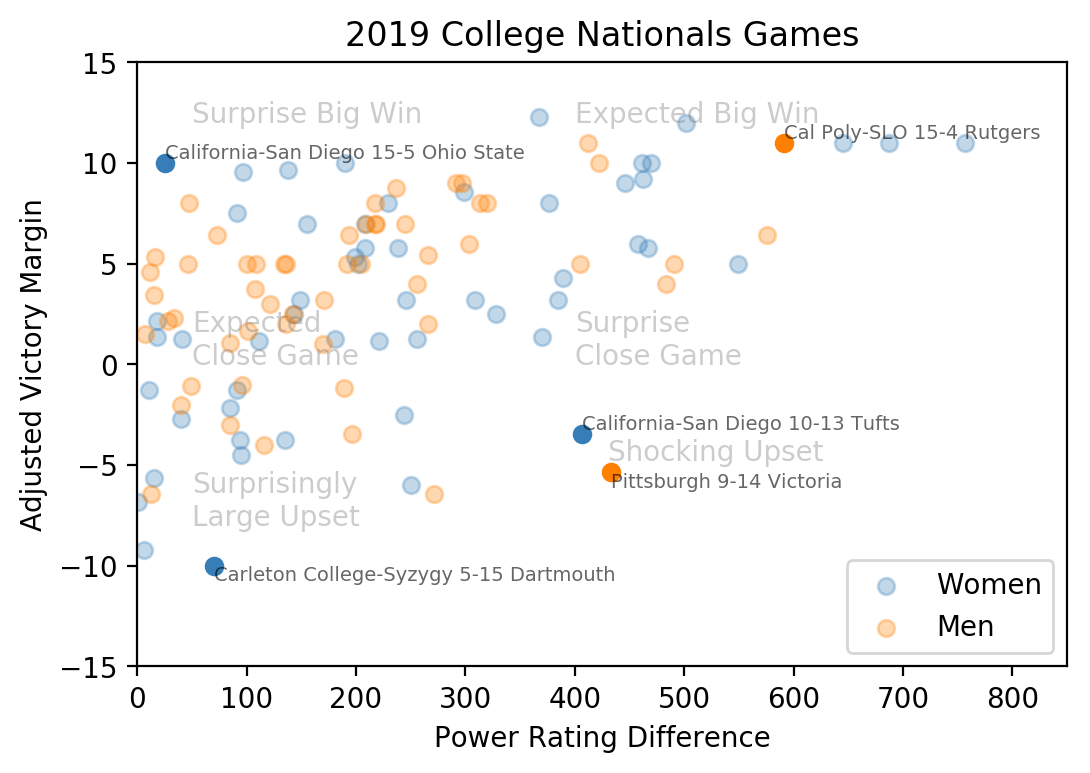

In [25]:
# Plot Women's and Men's results together

fig = plt.figure(figsize=(6,4), dpi=200)
fig.patch.set_facecolor('white')
alpha = 0.3 # points
alpha_game = 0.6 # Game info ('Pitt 11-15 Victoria')
fontsize_game = 7
plt.scatter(nationals_results_women['RatingDiff'], 
            nationals_results_women['GameTo15VictoryMargin'], 
            label='Women', color=colors[1], alpha=alpha)
plt.scatter(nationals_results_men['RatingDiff'], 
            nationals_results_men['GameTo15VictoryMargin'], 
            label='Men', color=colors[4], alpha=alpha)
# Men
for i in nationals_results_men.index.values:
    rating_diff_here = nationals_results_men['RatingDiff'].loc[i]
    gameto15_victory_margin_here = nationals_results_men['GameTo15VictoryMargin'].loc[i]
    
    text = '%s %i-%i %s' %(nationals_results_men['Team'].loc[i], 
                           nationals_results_men['Score'].loc[i].team_a, 
                           nationals_results_men['Score'].loc[i].team_b, 
                           nationals_results_men['Opponent'].loc[i])
    
    # Brown crushes UNC
    if rating_diff_here >= 400 and gameto15_victory_margin_here <= -5:
        plt.text(nationals_results_men['RatingDiff'].loc[i], 
                nationals_results_men['GameTo15VictoryMargin'].loc[i],
                text, horizontalalignment='left', verticalalignment='top',
                alpha=alpha_game, fontsize=fontsize_game)
        plt.scatter(nationals_results_men['RatingDiff'].loc[i], 
                    nationals_results_men['GameTo15VictoryMargin'].loc[i],
                    marker='o', color=colors[4])
        
    # Expected Cal Poly-SLO beats Rutgers
    if rating_diff_here >= 550 and gameto15_victory_margin_here >= 10:
        plt.text(nationals_results_men['RatingDiff'].loc[i], 
                nationals_results_men['GameTo15VictoryMargin'].loc[i],
                text, horizontalalignment='left', verticalalignment='bottom',
                alpha=alpha_game, fontsize=fontsize_game)
        plt.scatter(nationals_results_men['RatingDiff'].loc[i], 
                    nationals_results_men['GameTo15VictoryMargin'].loc[i],
                    marker='o', color=colors[4])

# Womens        
for i in nationals_results_women.index.values:
    rating_diff_here = nationals_results_women['RatingDiff'].loc[i]
    gameto15_victory_margin_here = nationals_results_women['GameTo15VictoryMargin'].loc[i]
    
    text = '%s %i-%i %s' %(nationals_results_women['Team'].loc[i], 
                           nationals_results_women['Score'].loc[i].team_a, 
                           nationals_results_women['Score'].loc[i].team_b, 
                           nationals_results_women['Opponent'].loc[i])
    
    # UCSD loses to Tufts
    if rating_diff_here >= 400 and gameto15_victory_margin_here <= -1:
        plt.text(nationals_results_women['RatingDiff'].loc[i], 
                nationals_results_women['GameTo15VictoryMargin'].loc[i],
                text, horizontalalignment='left', verticalalignment='bottom',
                alpha=alpha_game, fontsize=fontsize_game)
        plt.scatter(nationals_results_women['RatingDiff'].loc[i], 
                    nationals_results_women['GameTo15VictoryMargin'].loc[i],
                    marker='o', color=colors[1])
    
    # Dartmouth beats Carleton
    if rating_diff_here <= 400 and gameto15_victory_margin_here <= -10:
        plt.text(nationals_results_women['RatingDiff'].loc[i], 
                nationals_results_women['GameTo15VictoryMargin'].loc[i],
                text, horizontalalignment='left', verticalalignment='top',
                alpha=alpha_game, fontsize=fontsize_game)
        plt.scatter(nationals_results_women['RatingDiff'].loc[i], 
                    nationals_results_women['GameTo15VictoryMargin'].loc[i],
                    marker='o', color=colors[1])
    
    # UCSD beats Ohio State
    if rating_diff_here <= 100 and gameto15_victory_margin_here >= 10:
        plt.text(nationals_results_women['RatingDiff'].loc[i], 
                nationals_results_women['GameTo15VictoryMargin'].loc[i],
                text, horizontalalignment='left', verticalalignment='bottom',
                alpha=alpha_game, fontsize=fontsize_game)
        plt.scatter(nationals_results_women['RatingDiff'].loc[i], 
                    nationals_results_women['GameTo15VictoryMargin'].loc[i],
                    marker='o', color=colors[1])

alpha_interpretation = 0.4
plt.text(400,0, 'Surprise\nClose Game', color='gray', 
         alpha=alpha_interpretation)
plt.text(400,12, 'Expected Big Win', color='gray', 
         alpha=alpha_interpretation)
plt.text(50,0, 'Expected\nClose Game', color='gray', 
         alpha=alpha_interpretation)
plt.text(50,12, 'Surprise Big Win', color='gray', 
         alpha=alpha_interpretation)
plt.text(50,-8, 'Surprisingly\nLarge Upset', color='gray', 
         alpha=alpha_interpretation)
plt.text(430,-4.8, 'Shocking Upset', color='gray', 
         alpha=alpha_interpretation)
plt.xlim([0, 850])
plt.ylim([-15, 15])
plt.title('2019 College Nationals Games')
plt.xlabel('Power Rating Difference')
plt.ylabel('Adjusted Victory Margin')
plt.legend(loc='lower right')
plt.show()

